# Model Interpretability Tool Demo

This demo shows how LIME and SHAP can be used to explain a model (kernel SVM). 

For the demo we use the "What's Cooking?" dataset from Kaggle (more info [here](https://www.kaggle.com/c/whats-cooking/data)). The dataset is a list of ingredients for a recipe identified by the type of cuisine. The goal is to train a model to predict the cuisine from the ingredients list.


### Resources
The following resources were used for the installation and use of the tools
* [LIME tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Lime%20-%20basic%20usage%2C%20two%20class%20case.ipynb) by Ribeiro, Singh, and Guestrin
* [SHAP tutorial](https://github.com/slundberg/shap) by Lundberg and Lee

To get started we will import our model explanation tools (please install using the links above) and scikit-learn

In [50]:
import pickle
import pandas as pd
import shap
import re
from random import randint
from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

Now we load and process our dataset, which consists of a list of ingredients identified by a type of cuisine. The dataset comes in JSON form with ingredients as a list; this form does not work well with our model explaners (they expect raw text), so we will do a simple conversion from list to text before moving on.

Note we do not use the test data provided by Kaggle because it does not have labels. Instead we will just split the provided training data.

In [15]:
data_df = pd.read_json("data/train.json").set_index("id")

train_df = data_df.sample(frac=0.7)
test_df = data_df[~data_df.index.isin(train_df.index)]

def clean_ingredients(ingredient_list):
    s = ""
    for i in ingredient_list:
        i = re.sub("-|\s", "_", i.strip())
        s += f"{i} "
    return s[:-1]
    
train_df.ingredients = train_df.ingredients.map(lambda x: clean_ingredients(x))
test_df.ingredients = test_df.ingredients.map(lambda x: clean_ingredients(x))

/Users/alexandra/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Here is an example data point. We have a cuisine type and the (string) of ingredients in that recipe.

In [16]:
train_df.iloc[0]

cuisine                                                   french
ingredients    large_egg_yolks sea_salt sugar large_eggs corn...
Name: 13473, dtype: object

As features for our model we will use TFIDF for no reason other than it's simple.

In [18]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df.ingredients)
X_test = vectorizer.transform(test_df.ingredients)

In [19]:
# Check our vectorizer
print(f"There are {len(vectorizer.get_feature_names())} unique tokens")
vectorizer.get_feature_names()

There are 6196 unique tokens


['14',
 '14_oz',
 '15_oz',
 '25',
 '2_1',
 '2_to_3_lb',
 '33',
 '40',
 '5_oz',
 '7_up',
 '8_ounc_ziti_pasta',
 '95',
 '____oz',
 '___chicken_flavor',
 '___mexican_rice',
 '___oz',
 '_alfredo_sauce',
 '_all_purpose_sticks',
 '_arrabbiata_sauce',
 '_artisan_blends',
 '_baking_blend',
 '_beef_bouillon',
 '_butter',
 '_cajun_style_chicken_sausage',
 '_chicken',
 '_chicken_broth',
 '_chicken_flavor_bouillon_powder',
 '_chopped_green_chiles',
 '_chunky_mild_salsa',
 '_classic_pizza_crust',
 '_classico_olive_oil',
 '_cook_and_drain',
 '_cooked_and_drained',
 '_cookies',
 '_cream',
 '_crisp_cooked_and_crumbled',
 '_crush',
 '_cut_french_into_loaf',
 '_cut_into',
 '_cut_into_italian_loaf',
 '_cut_into_serving_pieces',
 '_dash',
 '_dash_seasoning_mix',
 '_diced_tomatoes',
 '_dip_mix',
 '_dips_mix',
 '_drain',
 '_drain_and_flake',
 '_drained_and_chopped',
 '_dressing',
 '_dressing_',
 '_dried_fish',
 '_eggs',
 '_farmhouse_originals_italian_with_herbs_dressing',
 '_fat_free_ham',
 '_fiesta_sides',
 '_fine_chop',
 '_greek_100_blackberry_pie_yogurt',
 '_greek_yogurt_original_ranch',
 '_green_chilies',
 '_half',
 '_home_originals',
 '_hot_italian_turkey_sausage_links',
 '_iced_tea_brew_family_size_tea_bags',
 '_kosher_salt',
 '_lean_ground_beef',
 '_less_sodium_chicken_broth',
 '_less_sodium_cooked_deli_ham',
 '_less_sodium_ham',
 '_less_sodium_smoked_fully_cooked_ham',
 '_less_sodium_taco_seasoning',
 '_less_sodium_taco_seasoning_mix',
 '_low_fat_buttermilk',
 '_low_fat_cheddar_chees',
 '_low_fat_chocolate_milk',
 '_low_fat_cottage_cheese',
 '_low_fat_milk',
 '_lowfat_greek_yogurt',
 '_made_with_olive_oil_spread',
 '_marinade',
 '_mild_italian_ground_sausage',
 '_mild_red_enchilada_sauce',
 '_milk',
 '_milk_finely_shredded_four_cheese',
 '_milkfat_low_fat_cottage_cheese',
 '_mixers_margarita_mix',
 '_monterey_jack_cheese',
 '_natural_sweetener',
 '_natural_vanilla_ice_cream',
 '_not_butter',
 '_oatmeal_cookie_mix',
 '_onion_soup_mix',
 '_or_best_food_light_mayonnais',
 '_or_best_food_real_mayonnais',
 '_original_cayenne_pepper_sauce',
 '_original_ranch',
 '_original_ranch_salad',
 '_pasta_sides',
 '_peel_and_devein',
 '_pepper',
 '_perrins_worcestershire_sauce',
 '_pure_vanilla_extract',
 '_real_mayonnaise',
 '_recipe_secrets',
 '_redhot',
 '_reduced_fat_milk',
 '_refried_beans',
 '_refrigerated_crescent_dinner_rolls',
 '_rins_and_drain',
 '_seasoning_mix',
 '_shredded_cheddar_cheese',
 '_shredded_parmesan_cheese',
 '_skinless_chicken_breast',
 '_slice',
 '_sliced',
 '_sliced_mushrooms',
 '_soften',
 '_spicy_ranch_dressing',
 '_spicy_sausage_slices',
 '_split_and_toasted',
 '_spread',
 '_superior',
 '_sweetened_condensed_milk',
 '_taco_seasoning_mix',
 '_thaw',
 '_thaw_and_drain',
 '_thawed_and_squeezed_dry',
 '_thick_',
 '_toasted_sesame_dressing_',
 '_tomato_paste',
 '_tomato_sauce',
 '_traditional_cut_shredded_4_cheese_mexican',
 '_undrain',
 '_undrain_and_chop',
 '_vegetable_recipe_mix',
 '_water',
 '_well_scrub',
 '_well_scrubbed',
 '_wine',
 '_yams',
 'a_taste_of_thai_rice_noodles',
 'abalone',
 'abbamele',
 'abura_age',
 'acai_juice',
 'accent',
 'accent_seasoning',
 'accompaniment',
 'achiote',
 'achiote_paste',
 'achiote_powder',
 'acini_di_pepe',
 'ackee',
 'acorn_squash',
 'activ',
 'active_dry_yeast',
 'adobo',
 'adobo_all_purpose_seasoning',
 'adobo_sauce',
 'adobo_seasoning',
 'adzuki_beans',
 'agar',
 'agar_agar_flakes',
 'agave_nectar',
 'agave_tequila',
 'aged_balsamic_vinegar',
 'aged_cheddar_cheese',
 'aged_gouda',
 'aged_manchego_cheese',
 'ahi',
 'ahi_tuna_steaks',
 'aioli',
 'ajinomoto',
 'ajwain',
 'aka_miso',
 'alaskan_king_crab_legs',
 'albacore',
 'albacore_tuna_in_water',
 'alcohol',
 'ale',
 'aleppo_pepper',
 'alexia_waffle_fries',
 'alfalfa_sprouts',
 'alfredo_sauce',
 'alfredo_sauce_mix',
 'all_potato_purpos',
 'all_purpose_flour',
 'all_purpose_seasoning',
 'all_purpose_unbleached_flour',
 'allspice',
 'allspice_berries',
 'almond_butter',
 'almond_extract',
 'almond_flour',
 'almond_liqueur',
 'almond_meal',


Time to train our model!

## Model Creation

Let's initialize our kernel SVM. Please note the large cache size and change it if you do not have that much memory! Alternatively, do not re-train the model and simply load the one in this repo (it takes a bit to train).

In [53]:
# Train model
clf = SVC(kernel="rbf", gamma="scale", probability=True)
clf.fit(X_train, train_df.cuisine)

# Dump
pickle.dump(clf, open("model_svm.pickle", "wb"))

In [35]:
# Load model
clf = pickle.load(open("model_svm.pickle", "rb"))

Model trained! Now we can check our model train and test accuracy

In [38]:
clf.predict_proba(X_train)[0]

array([1.12480073e-04, 6.86500935e-03, 6.75283087e-03, 1.47638905e-02,
       2.38466170e-03, 7.78712626e-01, 6.92402349e-03, 1.99386700e-03,
       3.68173899e-03, 3.93486114e-02, 1.81249805e-04, 1.45617051e-03,
       4.36859027e-04, 1.40972334e-02, 7.05605075e-05, 2.97633968e-02,
       3.69464867e-02, 5.09377483e-02, 1.30545568e-03, 3.26510009e-03])

In [37]:
train_score = sklearn.metrics.precision_recall_fscore_support(train_df.cuisine, 
                                                clf.predict_proba(X_train), 
                                                average="weighted")
test_score = sklearn.metrics.precision_recall_fscore_support(test_df.cuisine, 
                                                clf.predict_proba(X_test), 
                                                average="weighted")
print(f"Train F1: {train_score[2]}")
print(f"Test F1: {test_score[2]}")

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## Model Explanation with Feature Importance

...gotcha! In this example we are using a kernel (non-linear) SVM. 

## Model Explanation with LIME

We have our training and test F1 scores, now let's explore our model with LIME. The goal here is to understand which features our model is picking up on, and seeing how we can improve our feature engineering.

In [40]:
# Create sklearn pipeline as in LIME tutorial
pipe = sklearn.pipeline.make_pipeline(vectorizer, clf)

# Initialize LIME
class_names = train_df.cuisine.unique().tolist()
class_names.sort()
explainer_lime = lime_text.LimeTextExplainer(class_names=class_names)

Since LIME is a local model, we should pick a couple random samples to 

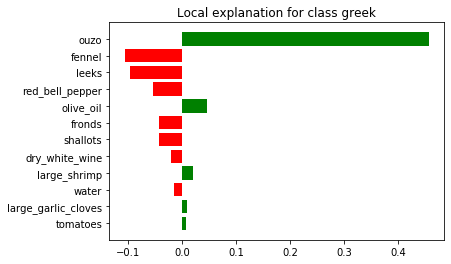

In [43]:
num_features = 20
test_sample = test_df.sample(n=1)
labels = [class_names.index(test_sample.cuisine.array[0]), randint(0, len(class_names)-1)]
exp = explainer_lime.explain_instance(test_sample.ingredients.values[0], 
                                 pipe.predict_proba, 
                                 num_features=num_features,
                                    labels=labels)

fig = exp.as_pyplot_figure(label=labels[0])
exp.show_in_notebook(text=True)

## Model Explanation with SHAP

In [49]:
explainer_shap = shap.KernelExplainer(clf.predict_proba, X_train, link="logit")
shap_values = explainer_shap.shap_values(X_test, nsamples=100)

Using 27842 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.165e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.945e-02, with an active set of 11 regressors, and the smallest chole

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.077e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.077e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.077e-02, with an active set of 17 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.511e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=2.256e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 8.689e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=2.256e-03, with an active set of 21 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.123e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.120e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=1.094e-01, with an active set of 13 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.634e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=8.187e-03, with an active set of 23 regressors, and the smallest chole

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=5.350e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=5.350e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=5.349e-03, with an active set of 18 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=9.907e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=9.598e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=8.709e-03, with an active set of 20 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=6.740e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=6.585e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=6.558e-02, with an active set of 15 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=4.469e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 63 iterations, i.e. alpha=4.307e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 63 iterations, i.e. alpha=4.307e-02, with an active set of 15 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=8.366e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=8.366e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=8.366e-03, with an active set of 23 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.025e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.013e-02, with an active set of 10 regressors, and the smallest choles

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.738e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.580e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.580e-01, with an active set of 11 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=1.227e-01, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=1.227e-01, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=1.226e-01, with an active set of 18 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 86 iterations, i.e. alpha=1.366e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 123 iterations, i.e. alpha=6.983e-04, with an active set of 33 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 123 iterations, i.e. alpha=6.983e-04, with an active set of 33

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.160e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=6.021e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=5.011e-02, with an active set of 13 reg

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.186e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.163e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 44 iterations, i.e. alpha=2.155e-02, with an active set of 18 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.932e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.781e-02, with an active set of 2 regressors, and the smallest cholesky 

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 69 iterations, alpha=4.096e-02, previous alpha=4.096e-02, with an active set of 20 regressors.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.210e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.105e-01, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.105e-01, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.104e-01, with an active set of 13 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.749e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.749e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.749e-02, with an active set of 9 regr

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 87 iterations, i.e. alpha=1.119e-03, with an active set of 37 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=5.577e-04, with an active set of 38 regressors, and the smallest chol

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.857e-01, with an active set of 14 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.857e-01, with an active set of 14 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.857e-01, with an active set of 14 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.073e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.073e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.149e-02, with an active set of 10 regre

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.181e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.181e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.181e-01, with an active set of 4 regress

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.468e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.190e-01, with an active set of 5 regressors, and the smallest cholesky 

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=5.756e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 109 iterations, i.e. alpha=4.696e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 118 iterations, i.e. alpha=3.636e-03, with an active set of 28

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:604: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=1.518e-02, previous alpha=1.516e-02, with an active set of 19 regressors.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.984e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.365e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.024e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.852e-01, with an active set of 7 regress

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.981e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.217e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.973e-02, with an active set of 11 regre

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.063e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.031e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.031e-01, with an active set of 7 regr

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.570e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.363e-01, with an active set of 4 regressors, and the smallest cholesky 

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.392e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.854e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.854e-02, with an active set of 10 re

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.164e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=1.954e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.632e-01, with an active set of 13 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.372e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.372e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.372e-01, with an active set of 9 regr

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.150e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.150e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.149e-01, with an active set of 8 regr

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.099e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.098e-01, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.098e-01, with an active set of 10 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.514e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.176e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.166e-01, with an active set of 13 reg

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.688e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.688e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.291e-01, with an active set of 13 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.621e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.620e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.620e-02, with an active set of 13 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.058e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=9.681e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=9.377e-03, with an active set of 16 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.005e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.005e-01, with an active set of 2 regressors, and the smallest cholesky 

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.903e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.903e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.900e-02, with an active set of 12 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.368e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 7.224e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.368e-01, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.363e-01, with an active set of 12 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.457e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.268e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.267e-02, with an active set of 16 r

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.413e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.413e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.187e-01, with an active set of 6 regress

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.417e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.005e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.678e-01, with an active set of 5 regress

/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.887e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.887e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/alexandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.149e-02, with an active set of 12 r

KeyboardInterrupt: 

In [46]:
# Note: use "independent" condition because it is truer to the model
explainer = shap.LinearExplainer(svm, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

Exception: An unknown model type was passed: <class 'sklearn.svm.classes.LinearSVC'>

In [ ]:
shap_values = explainer_shap.shap_values(X_test, nsamples=10)

In [ ]:
# plot the SHAP values for the last used test sample in LIME, for comparison
idx = test_sample.index
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")